In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [33]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm

In [3]:
import os
try:
    _ = os.environ.pop("TILED_API_KEY")
except KeyError:
    pass

In [4]:
sys.path.append("NSLS-II-ISS-xview")

In [5]:
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['text.usetex'] = False
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)
mpl.rcParams['figure.dpi'] = 300

In [6]:
from tiled.client import from_uri
from tiled.queries import Key

In [7]:
from xview.xasproject.xasproject import XASDataSet

In [8]:
c = from_uri("https://tiled-demo.blueskyproject.io", api_key=None)
c.login()


You have 15 minutes visit this URL

  https://orcid.org/oauth/authorize?client_id=APP-0ROS9DU5F717F7XN&response_type=code&scope=openid&redirect_uri=https%3A%2F%2Ftiled-demo.blueskyproject.io%2Fapi%2Fv1%2Fauth%2Fprovider%2Forcid%2Fdevice_code

and enter the code:

  9970-C153


Waiting.......
You have logged in with ORCID as 0000-0002-5181-9513.


# 231001 NMC analysis

In [59]:
def get_container(dataset="nmc", element="Ni", beamline="ISS"):
    d = c['aimm'].search(Key('dataset') == dataset)\
        .search(Key('element.symbol') == element)\
        .search(Key('beamline.name') == beamline)
    return d

def process_data(container):
    indices = list(container)
    spectra = []
    for index in tqdm(indices):
        spectrum = {}
        sp = c['aimm'][index]
        spectrum['index'] = index
        spectrum['metadata'] = sp.metadata
        spectrum['energy'] = np.array(sp.read(['energy'])['energy'])
        spectrum['murefer'] = np.array(sp.read(['murefer'])['murefer'])
        spectrum['mutrans'] = np.array(sp.read(['mutrans'])['mutrans'])
        spectrum['mufluor'] = np.array(sp.read(['mufluor'])['mufluor'])
        spectra.append(spectrum)
    return spectra

def postprocess_data(data):
    norm_spectra = []
    for i in tqdm(range(len(data))):
        try:
            a=XASDataSet(energy=data[i]['energy'], mu=data[i]['mutrans'])
            a.norm1=50
            a.norm2=600
            a.normalize_force()
        except ValueError:
            continue
        norm_spectrum = {}
        norm_spectrum['energy']=list(a.energy)
        norm_spectrum['mu']=list(a.flat)
        norm_spectrum['metadata']=dict(data[i]['metadata'])
        norm_spectra.append(norm_spectrum)
        
    return norm_spectra

In [24]:
Ni = get_container(element="Ni")
Mn = get_container(element="Mn")
Co = get_container(element="Co")

In [35]:
Ni_data = process_data(Ni)
Mn_data = process_data(Mn)
Co_data = process_data(Co)

100%|███████████████████████████████████████████| 39/39 [00:20<00:00,  1.90it/s]


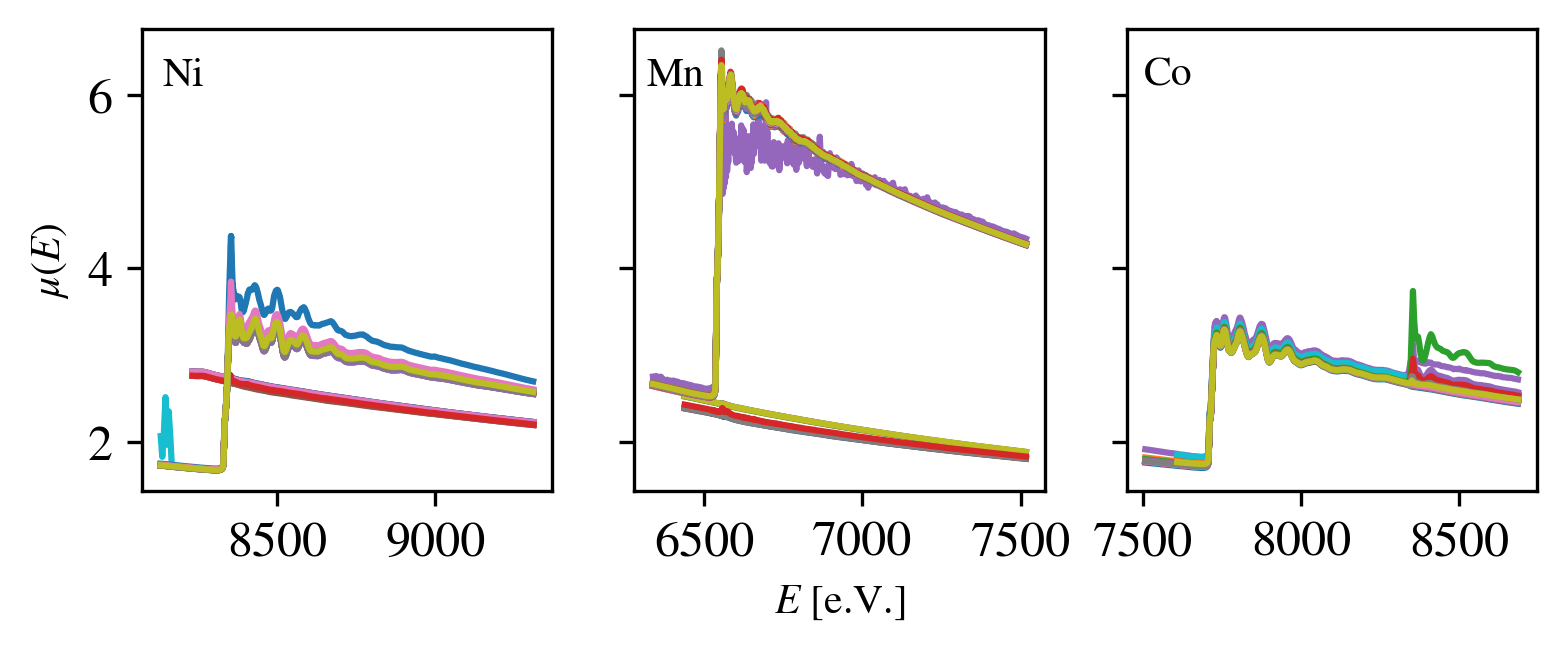

In [50]:
fig, axs = plt.subplots(1, 3, figsize=(6, 2), sharey=True)

ax = axs[0]
for i in range(len(Ni_data)): 
    ax.plot(Ni_data[i]['energy'], Ni_data[i]['murefer'])
ax.set_ylabel("$\mu(E)$")
ax.text(0.1, 0.9, "Ni", ha="center", va="center", transform=ax.transAxes)
    
ax = axs[1]
for i in range(len(Ni_data)): 
    ax.plot(Mn_data[i]['energy'], Mn_data[i]['murefer'])
ax.set_xlabel("$E$ [e.V.]")
ax.text(0.1, 0.9, "Mn", ha="center", va="center", transform=ax.transAxes)

ax = axs[2]
for i in range(len(Ni_data)): 
    ax.plot(Co_data[i]['energy'], Co_data[i]['murefer'])
ax.text(0.1, 0.9, "Co", ha="center", va="center", transform=ax.transAxes)

plt.show()

In [60]:
Ni_data_post = postprocess_data(Ni_data)
Mn_data_post = postprocess_data(Mn_data)
Co_data_post = postprocess_data(Co_data)

100%|███████████████████████████████████████████| 39/39 [00:01<00:00, 21.05it/s]


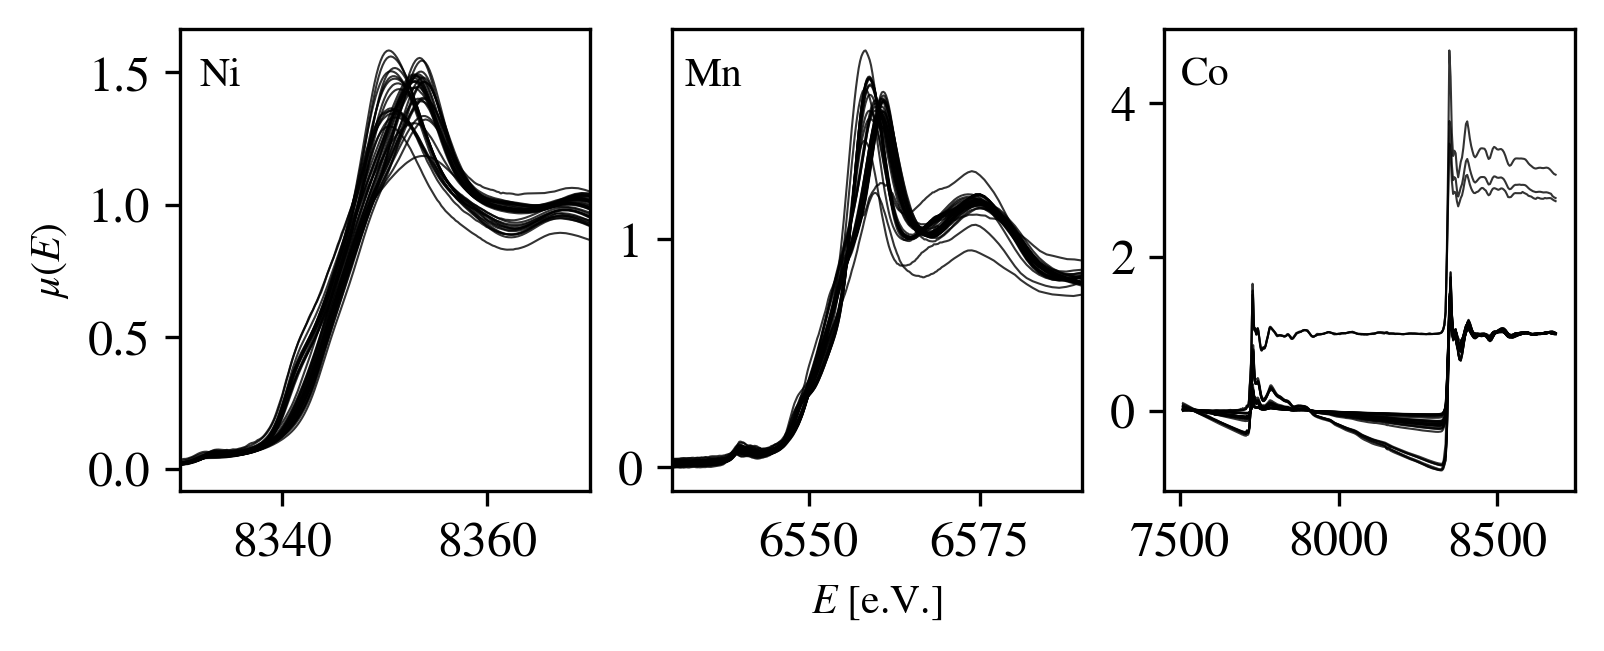

In [80]:
fig, axs = plt.subplots(1, 3, figsize=(6, 2), sharey=False)

ax = axs[0]
for i in range(len(Ni_data_post)): 
    ax.plot(Ni_data_post[i]['energy'], Ni_data_post[i]['mu'], color="black", alpha=0.8, linewidth=0.5)
ax.set_ylabel("$\mu(E)$")
ax.text(0.1, 0.9, "Ni", ha="center", va="center", transform=ax.transAxes)
ax.set_xlim(8330, 8370)
    
ax = axs[1]
for i in range(len(Ni_data_post)): 
    ax.plot(Mn_data_post[i]['energy'], Mn_data_post[i]['mu'], color="black", alpha=0.8, linewidth=0.5)
ax.set_xlabel("$E$ [e.V.]")
ax.text(0.1, 0.9, "Mn", ha="center", va="center", transform=ax.transAxes)
ax.set_xlim(6530, 6590)


ax = axs[2]
for i in range(len(Ni_data_post)): 
    ax.plot(Co_data_post[i]['energy'], Co_data_post[i]['mu'], color="black", alpha=0.8, linewidth=0.5)
ax.text(0.1, 0.9, "Co", ha="center", va="center", transform=ax.transAxes)

plt.show()